# Spotify API Music Genre Classification Capstone <br>
Finding new music can be a pain - and what better way to do that than exploring the genres that catch your interest! <br><br>
This project explores the viability of using Spotify track features to develop a genre classification system using track feature data from several genre-based playlists. Being able to accurately classify a genre for a novel song may be a marketable product for amateur music producers!

In [2]:
from dotenv import load_dotenv
import os
import base64
from requests import post, get
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

In [3]:
#Need token to make api calls
def get_token():
    auth_string = client_id + ':' + client_secret
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')
    
    url = 'https://accounts.spotify.com/api/token'
    headers = {
        'Authorization': 'Basic ' + auth_base64,
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    data = {'grant_type': 'client_credentials'}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result['access_token']
    return token

def get_auth_header(token):
    return {'Authorization': 'Bearer ' + token}

#Search api by artist name in string form
def search_artist(token, artist_name):
    url = 'https://api.spotify.com/v1/search'
    headers = get_auth_header(token)
    query = f'?q={artist_name}&type=artist&limit=1'
    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)['artists']['items']
    
    if len(json_result) == 0:
        print('No results')
        return None
    
    return json_result[0]

#Get top tracks of a given artist using artist id
def get_songs(token, artist_id):
    url = f'https://api.spotify.com/v1/artists/{artist_id}/top-tracks?country=US'
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)['tracks']
    return json_result

#Get tracks based on track id
def get_tracks(token, track_id):
    url = f'https://api.spotify.com/v1/tracks/{track_id}'
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)
    return json_result

#Get audio features of multiple tracks. Could not get this working, unused
def get_afs(token, track_id):
    url = f'https://api.spotify.com/v1/audio-features'
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)
    return json_result

#Get audio features of single track
def get_af(token, track_id):
    url = f'https://api.spotify.com/v1/audio-features/{track_id}'
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)
    return json_result

#Find track by inputting track name. Did not work
def search_track(token, track_name):
    url = 'https://api.spotify.com/v1/search'
    headers = get_auth_header(token)
    query = f'?q={track_name}&type=track&limit=1'
    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)
    
    if len(json_result) == 0:
        print('No results')
        return None

#Get audio features of a track using the track id
def track_details(token, track_id):
    url = 'https://api.spotify.com/v1/audio-features'
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)['audio_features']['items']
    return json_result

#Search playlist by playlist name in string form
def search_playlist(token, playlist_name):
    url = 'https://api.spotify.com/v1/search'
    headers = get_auth_header(token)
    query = f'?q={playlist_name}&type=playlist&limit=3'
    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)['playlists']['items']
    
    if len(json_result) == 0:
        print('No results')
        return None
    
    return json_result[0]

#Search playlists for one made by Spotify for better standardization of data
def search_playlist_sp(token, playlist_name):
    url = 'https://api.spotify.com/v1/search'
    headers = get_auth_header(token)
    query = f'?q={playlist_name}&type=playlist&offset=1&limit=3'
    query_url = url + query
    result = get(query_url, headers=headers)
    json_result = json.loads(result.content)['playlists']['items']
    
    if len(json_result) == 0:
        print('No results')
        return None
    
    return json_result[0]

#Get dictionary of tracks and data from a given playlist
def get_songs_pl(token, pl_id):
    url = f'https://api.spotify.com/v1/playlists/{pl_id}'
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)['tracks']
    return json_result

#Get track id from all tracks in playlist
def track_id_from_playlist(token, pl_id):
    headers = get_auth_header(token)
    result = get(pl_id, headers=headers)
    json_result = json.loads(result.content)
    return json_result

#Get genres based on artist. Unreliable method to determine genre, so I ended up using a different approach instead.
def genre(token, artist_id):
    url = f'https://api.spotify.com/v1/artists/{artist_id}'
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)['genres']
    return json_result

After much reading, testing, and tinkering, I found the following segments of code to be useful in generating a dataframe with the desired features and songs.

In [4]:
#print(get_tracks(token, '0ZlacvDIHlKE1d6qzLjltK'))    #GETS TRACK DATA USING TRACK ID
#search_artist(token, 'Deadmau5')['genres']    #FIND GENRES BASED ON ARTIST
#get_af(token, '0ZlacvDIHlKE1d6qzLjltK')      #GET TRACK FEATURES
#playlist_url = search_playlist(token, 'house mix')['tracks']['href']    #GET PLAYLIST URL
#len(get_songs_2(token, plurl)['items'])     #length of playlist

#playlist_url = search_playlist(token, 'house mix')['tracks']['href']     #gets playlist url
#other_track_id = get_songs_2(token, playlist_url)['items'][0]['track']['id']     #gets track ID with search_playlist
#get_songs_pl(token, '0zLS8rpKCrgl5g8IfFJ0Xn')['items'][0]['track']['id']         #gets track ID from playlist
#get_tracks(token, track_ids[0])['name']    #Gets name of current song.
#list(get_af(token, track_ids[trackid]).values())     #GETS ROW OF DATA TO ADD TO DF

Now, time to test out some API calls!

In [5]:
token = get_token()   #EXAMPLE SO I DON'T FORGET HOW THIS WORKS
result = search_artist(token, 'Qrion')
artist_id = result['id']
songs = get_songs(token, artist_id)

for idx, song in enumerate(songs):
    print(f"{idx + 1}. {song['name']}")

1. Your Love
2. Breathe - Qrion Remix
3. Outro
4. Proud
5. Monolith
6. 11-11
7. Fireworks
8. Satisfied - Qrion Remix
9. Odyssey - Remix
10. Foggy August


In [38]:
qrionlist = []
for song in songs:
    qrionlist.append(song['id'])
print(qrionlist)

['0ZlacvDIHlKE1d6qzLjltK', '7lZjor53FqYpyJb8Uc0Pve', '2WlnczYDjRaMZNZCrCuxxo', '5COxPQbNaVMsLEr3tuicvp', '5HUQByo24AQbWzEEWJeBiB', '62wVX3kygCdOPPkdePi4pg', '0mogpLJRPJTCCdy5yV9qhl', '75s1E7gtxXQaKkHMyOOtOp', '2kAyzZVHgF9A69Ejp1ng5E', '4SjnPw9vvM51tScELQ0PHz']


<font size='4'>To build the dataframe we need, my approach is to find genre-specific playlists, get those tracks, and get audio features for each track. This approach is based on circumventing the following problems:</font> <br>
First, I could only find genre data for albums and artists, not individual tracks. Furthermore, there were often multiple genres per artist or album: there was no clear way to determine the best fitting genre, and many are subgenres of my genres of interest. <br>
Second, I was unable to search for specific tracks effectively, so using a playlist to get the track IDs (which I needed to get audio features) helped me avoid this issue.

<font size="4">Now, time to get to work building the dataframe.</font> <br>
We're going to get each playlist for each genre using function get_playlist() above, which returns the playlist ID. Then, we want to input that ID to get_songs_2() to get the song IDs for that playlist. We iterate through this, using get_af() on each song ID in the playlist to output the tracks' audio features, storing them in a dictionary. <br>
Finally, we convert that dictionary into a dataframe to merge with the existing dataframe, iterating over each song selected in the dataset.

In [20]:
list_genres = ['House Mix', 'Trance Mix', 'Techno Mix', 'DnB Mix', 'Dubstep Mix', 'IDM Mix', 'Synthwave Mix', 'Electro Mix']
list_genres2 = ['House', 'Trance', 'Techno', 'DnB', 'Dubstep', 'IDM', 'Synthwave', 'Electro']
song_names = []
genres = []
df = pd.DataFrame(columns=(get_af(token, '0mogpLJRPJTCCdy5yV9qhl')).keys())

for genre in range(len(list_genres)):
    playlist_url = search_playlist(token, list_genres[genre])['tracks']['href']
    playlist_items = track_id_from_playlist(token, playlist_url)['items']
    track_ids = []
    for i in range(50):
        track_ids.append(playlist_items[i]['track']['id'])
        song_names.append(get_tracks(token, track_ids[i])['name'])
        genres.append(list_genres2[genre])
        #print(track_ids)
        newdf = pd.DataFrame([list(get_af(token, track_ids[i]).values())], columns=df.columns)
        df = pd.concat([df, newdf], ignore_index=True)

Let's add the Genre column using the list we made, set indices to song names, and check to make sure the dataframe came out correctly.

In [34]:
df['Genre'] = genres
df.index = song_names
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Genre
Ferrari,0.844,0.688,1,-7.879,0,0.049,0.0129,0.000054,0.0492,0.695,124.992,audio_features,5xKJI9aPQhuTdTq8BrJ8fL,spotify:track:5xKJI9aPQhuTdTq8BrJ8fL,https://api.spotify.com/v1/tracks/5xKJI9aPQhuT...,https://api.spotify.com/v1/audio-analysis/5xKJ...,185662,4,House
Baby Don't Hurt Me,0.602,0.91,7,-3.404,1,0.0308,0.00126,0.000174,0.12,0.228,127.944,audio_features,3BKD1PwArikchz2Zrlp1qi,spotify:track:3BKD1PwArikchz2Zrlp1qi,https://api.spotify.com/v1/tracks/3BKD1PwArikc...,https://api.spotify.com/v1/audio-analysis/3BKD...,140018,4,House
Miss You,0.587,0.742,6,-6.64,0,0.0529,0.0128,0.00107,0.146,0.199,145.007,audio_features,73vIOb4Q7YN6HeJTbscRx5,spotify:track:73vIOb4Q7YN6HeJTbscRx5,https://api.spotify.com/v1/tracks/73vIOb4Q7YN6...,https://api.spotify.com/v1/audio-analysis/73vI...,206000,4,House
I'm Good (Blue),0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.371,0.304,128.04,audio_features,4uUG5RXrOk84mYEfFvj3cK,spotify:track:4uUG5RXrOk84mYEfFvj3cK,https://api.spotify.com/v1/tracks/4uUG5RXrOk84...,https://api.spotify.com/v1/audio-analysis/4uUG...,175238,4,House
The Motto,0.754,0.763,7,-4.627,0,0.0435,0.0301,0.000022,0.0901,0.464,117.953,audio_features,18asYwWugKjjsihZ0YvRxO,spotify:track:18asYwWugKjjsihZ0YvRxO,https://api.spotify.com/v1/tracks/18asYwWugKjj...,https://api.spotify.com/v1/audio-analysis/18as...,164819,4,House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Better Time,0.793,0.44,7,-5.635,1,0.037,0.234,0.000373,0.0875,0.187,120.023,audio_features,4VNitd6KZNDlAabGK4gK7c,spotify:track:4VNitd6KZNDlAabGK4gK7c,https://api.spotify.com/v1/tracks/4VNitd6KZNDl...,https://api.spotify.com/v1/audio-analysis/4VNi...,196062,4,Electro
Take My Love,0.672,0.955,8,-5.766,0,0.0434,0.00626,0.518,0.27,0.255,126.02,audio_features,0osz6OhmqmYcmYoMU0MP74,spotify:track:0osz6OhmqmYcmYoMU0MP74,https://api.spotify.com/v1/tracks/0osz6OhmqmYc...,https://api.spotify.com/v1/audio-analysis/0osz...,194286,4,Electro
Good Life - feat. mimiko,0.68,0.841,0,-6.03,1,0.0395,0.00562,0.000081,0.142,0.19,123.029,audio_features,15vktwvhLlloOkXlyvxZn1,spotify:track:15vktwvhLlloOkXlyvxZn1,https://api.spotify.com/v1/tracks/15vktwvhLllo...,https://api.spotify.com/v1/audio-analysis/15vk...,227562,4,Electro
All or Nothing,0.616,0.869,11,-4.164,1,0.0584,0.0436,0.000002,0.0803,0.286,128.05,audio_features,0Kwq7KPBeyMbV38q9LQnaq,spotify:track:0Kwq7KPBeyMbV38q9LQnaq,https://api.spotify.com/v1/tracks/0Kwq7KPBeyMb...,https://api.spotify.com/v1/audio-analysis/0Kwq...,183750,4,Electro


Save the dataframe to avoid long API calls!

In [36]:
#df.to_csv('~\Documents\SpringboardNew\song_data.csv')

Now to reload it from our saved file for some preliminary analysis and wrangling.

In [4]:
song_data = pd.read_csv('~\Documents\SpringboardNew\song_data.csv')
#song_data.index = song_data[:, 0]
#song_data.head()
song_data.rename(columns={'Unnamed: 0':'song_name'}, inplace=True)
song_data.index = song_data['song_name']
song_data = song_data.drop('song_name', axis=1)
song_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Genre
song_name,,,,,,,,,,,,,,,,,,,
Ferrari,0.844,0.688,1,-7.879,0,0.0490,0.01290,0.000054,0.0492,0.695,124.992,audio_features,5xKJI9aPQhuTdTq8BrJ8fL,spotify:track:5xKJI9aPQhuTdTq8BrJ8fL,https://api.spotify.com/v1/tracks/5xKJI9aPQhuT...,https://api.spotify.com/v1/audio-analysis/5xKJ...,185662,4,House
Baby Don't Hurt Me,0.602,0.910,7,-3.404,1,0.0308,0.00126,0.000174,0.1200,0.228,127.944,audio_features,3BKD1PwArikchz2Zrlp1qi,spotify:track:3BKD1PwArikchz2Zrlp1qi,https://api.spotify.com/v1/tracks/3BKD1PwArikc...,https://api.spotify.com/v1/audio-analysis/3BKD...,140018,4,House
Miss You,0.587,0.742,6,-6.640,0,0.0529,0.01280,0.001070,0.1460,0.199,145.007,audio_features,73vIOb4Q7YN6HeJTbscRx5,spotify:track:73vIOb4Q7YN6HeJTbscRx5,https://api.spotify.com/v1/tracks/73vIOb4Q7YN6...,https://api.spotify.com/v1/audio-analysis/73vI...,206000,4,House
I'm Good (Blue),0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,audio_features,4uUG5RXrOk84mYEfFvj3cK,spotify:track:4uUG5RXrOk84mYEfFvj3cK,https://api.spotify.com/v1/tracks/4uUG5RXrOk84...,https://api.spotify.com/v1/audio-analysis/4uUG...,175238,4,House
The Motto,0.754,0.763,7,-4.627,0,0.0435,0.03010,0.000022,0.0901,0.464,117.953,audio_features,18asYwWugKjjsihZ0YvRxO,spotify:track:18asYwWugKjjsihZ0YvRxO,https://api.spotify.com/v1/tracks/18asYwWugKjj...,https://api.spotify.com/v1/audio-analysis/18as...,164819,4,House


Now, let's get a general understanding of our data.

In [5]:
song_data.shape

(400, 19)

In [6]:
song_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.618153,0.805326,5.627500,-6.597583,0.50750,0.089439,0.109667,0.403297,0.210025,0.356754,128.285802,233788.350000,3.925000
std,0.139075,0.169920,3.567992,4.025589,0.50057,0.088676,0.214185,0.393832,0.165129,0.239077,24.053271,88106.124875,0.424057
min,0.000000,0.008980,0.000000,-32.203000,0.00000,0.000000,0.000004,0.000000,0.037400,0.000000,0.000000,37627.000000,0.000000
25%,0.537500,0.730750,2.000000,-8.332000,0.00000,0.040675,0.002570,0.000895,0.098525,0.153500,121.965500,177003.250000,4.000000
50%,0.622500,0.857500,6.000000,-6.024000,1.00000,0.056300,0.019750,0.284500,0.137000,0.330500,129.982000,220482.000000,4.000000
75%,0.713250,0.929250,9.000000,-4.285500,1.00000,0.096525,0.077925,0.834000,0.276500,0.532500,138.009000,275703.250000,4.000000
max,0.950000,0.998000,11.000000,2.185000,1.00000,0.662000,0.995000,0.978000,0.932000,0.969000,200.034000,584586.000000,5.000000


In [7]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, Ferrari to Unstoppable
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      400 non-null    float64
 1   energy            400 non-null    float64
 2   key               400 non-null    int64  
 3   loudness          400 non-null    float64
 4   mode              400 non-null    int64  
 5   speechiness       400 non-null    float64
 6   acousticness      400 non-null    float64
 7   instrumentalness  400 non-null    float64
 8   liveness          400 non-null    float64
 9   valence           400 non-null    float64
 10  tempo             400 non-null    float64
 11  type              400 non-null    object 
 12  id                400 non-null    object 
 13  uri               400 non-null    object 
 14  track_href        400 non-null    object 
 15  analysis_url      400 non-null    object 
 16  duration_ms       400 non-null    i

So far, here are some considerations for data wrangling: <br>
1) Some of these features aren't useful: we will want to drop the following columns: type, id, uri, track_href, and analysis_url. <br>
2) Tempo: we'll want to round the tempo values to the nearest ones place, and our analysis shows a min tempo value of 0 which is impossible! We will likely impute, hopefully with the actual values. I'll have to check for tempos under 40 bpm as none of these would be realistic. <br>
3) The loudness feature has a zero point crossing (min=-32, max=2), so I will add 34 to the column values to get them between 1-37 dB.

In [11]:
drop_cols = ['type', 'id', 'uri', 'track_href', 'analysis_url']  #drop these columns
song_data = song_data.drop(columns=drop_cols, axis=1)
song_data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Genre
song_name,,,,,,,,,,,,,,
Ferrari,0.844,0.688,1,-7.879,0,0.0490,0.01290,0.000054,0.0492,0.695,124.992,185662,4,House
Baby Don't Hurt Me,0.602,0.910,7,-3.404,1,0.0308,0.00126,0.000174,0.1200,0.228,127.944,140018,4,House
Miss You,0.587,0.742,6,-6.640,0,0.0529,0.01280,0.001070,0.1460,0.199,145.007,206000,4,House
I'm Good (Blue),0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238,4,House
The Motto,0.754,0.763,7,-4.627,0,0.0435,0.03010,0.000022,0.0901,0.464,117.953,164819,4,House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Better Time,0.793,0.440,7,-5.635,1,0.0370,0.23400,0.000373,0.0875,0.187,120.023,196062,4,Electro
Take My Love,0.672,0.955,8,-5.766,0,0.0434,0.00626,0.518000,0.2700,0.255,126.020,194286,4,Electro
Good Life - feat. mimiko,0.680,0.841,0,-6.030,1,0.0395,0.00562,0.000081,0.1420,0.190,123.029,227562,4,Electro


Looks good. Now, we check out the tempo. These really should be integer values, so we will convert them and find the unique tempo values.

In [23]:
song_data.tempo.round().unique().astype(int)

array([125, 128, 145, 118, 123, 132, 126, 116, 124, 122, 129, 108, 120,
       106, 115, 121, 138, 130, 136, 131, 137, 135, 140, 133, 134, 155,
       150, 160, 127, 153,  75, 144, 174, 175,  87, 172,  88, 180, 179,
       176, 105,  85, 113, 109, 147,  70, 110,  94, 100,  80,  76, 102,
       148, 146,  90,   0, 167, 117,  91, 139, 156, 101,  93,  53, 171,
       169, 114,  73, 200,  95,  96, 104,  83,  81,  92, 111,  98, 198,
        84,  78])

In [24]:
song_data[song_data['tempo'] < 40]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Genre
song_name,,,,,,,,,,,,,,
Krabs,0.0,0.628,1,-14.741,1,0.0,0.261,0.798,0.129,0.0,0.0,156246,0,IDM
Amnioverse,0.0,0.602,7,-10.703,1,0.0,0.349,0.689,0.110,0.0,0.0,246400,0,IDM


Alright - these are the only two songs with unreasonably low tempos (considering the genres we're working with), so we can just impute these per case. After checking the audio data with an analyzer, I found Krabs by Kettel to be 100 bpm. Amnioverse by Lapalux was more readily available, found to be 101 bpm with a quick Google search.

In [25]:
song_data['tempo']['Krabs'] = 100
song_data['tempo']['Amnioverse'] = 101

C:\Users\JAMESBOULESDAKEEK\AppData\Local\Temp\ipykernel_7552\4171500496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_data['tempo']['Krabs'] = 100
C:\Users\JAMESBOULESDAKEEK\AppData\Local\Temp\ipykernel_7552\4171500496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_data['tempo']['Amnioverse'] = 101


In [31]:
print(song_data['tempo']['Krabs'], song_data['tempo']['Amnioverse'])
print(song_data[song_data['tempo'] == 0])

100.0 101.0
Empty DataFrame
Columns: [danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature, Genre]
Index: []


Great, now to convert loudness to a positive decibel range:

In [33]:
song_data['loudness'] = song_data['loudness']+34

In [35]:
song_data['loudness'].describe()

count    400.000000
mean      27.402418
std        4.025589
min        1.797000
25%       25.668000
50%       27.976000
75%       29.714500
max       36.185000
Name: loudness, dtype: float64

In [37]:
song_data.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Genre
song_name,,,,,,,,,,,,,,
Ferrari,0.844,0.688,1,26.121,0,0.0490,0.01290,0.000054,0.0492,0.695,124.992,185662,4,House
Baby Don't Hurt Me,0.602,0.910,7,30.596,1,0.0308,0.00126,0.000174,0.1200,0.228,127.944,140018,4,House
Miss You,0.587,0.742,6,27.360,0,0.0529,0.01280,0.001070,0.1460,0.199,145.007,206000,4,House
I'm Good (Blue),0.561,0.965,7,30.327,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238,4,House
The Motto,0.754,0.763,7,29.373,0,0.0435,0.03010,0.000022,0.0901,0.464,117.953,164819,4,House
Let Me Love You,0.628,0.801,3,27.937,0,0.0374,0.08660,0.128000,0.1240,0.668,125.003,138240,4,House
Friday (feat. Mufasa & Hypeman) - Dopamine Re-Edit,0.824,0.862,2,30.576,1,0.1260,0.00760,0.000132,0.3030,0.801,122.980,169153,4,House
Afraid To Feel,0.578,0.912,1,30.071,1,0.1140,0.01660,0.003620,0.2730,0.680,127.870,177525,4,House
Turn On The Lights again.. (feat. Future),0.683,0.887,6,29.056,0,0.0497,0.01250,0.446000,0.3180,0.551,132.007,267947,4,House


In [38]:
from sklearn.utils import shuffle

In [41]:
shuffle(song_data).loc['Ferrari']

danceability           0.844
energy                 0.688
key                        1
loudness              26.121
mode                       0
speechiness            0.049
acousticness          0.0129
instrumentalness    0.000054
liveness              0.0492
valence                0.695
tempo                124.992
duration_ms           185662
time_signature             4
Genre                  House
Name: Ferrari, dtype: object

We will likely want to shuffle the records later for test train splits to give better genre variety, but I didn't save the variable for now, and we can do that when needed. Let's take a second to reevaluate the dataframe overall.

In [42]:
song_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Genre
song_name,,,,,,,,,,,,,,
Ferrari,0.844,0.688,1,26.121,0,0.0490,0.01290,0.000054,0.0492,0.695,124.992,185662,4,House
Baby Don't Hurt Me,0.602,0.910,7,30.596,1,0.0308,0.00126,0.000174,0.1200,0.228,127.944,140018,4,House
Miss You,0.587,0.742,6,27.360,0,0.0529,0.01280,0.001070,0.1460,0.199,145.007,206000,4,House
I'm Good (Blue),0.561,0.965,7,30.327,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238,4,House
The Motto,0.754,0.763,7,29.373,0,0.0435,0.03010,0.000022,0.0901,0.464,117.953,164819,4,House


In [43]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, Ferrari to Unstoppable
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      400 non-null    float64
 1   energy            400 non-null    float64
 2   key               400 non-null    int64  
 3   loudness          400 non-null    float64
 4   mode              400 non-null    int64  
 5   speechiness       400 non-null    float64
 6   acousticness      400 non-null    float64
 7   instrumentalness  400 non-null    float64
 8   liveness          400 non-null    float64
 9   valence           400 non-null    float64
 10  tempo             400 non-null    float64
 11  duration_ms       400 non-null    int64  
 12  time_signature    400 non-null    int64  
 13  Genre             400 non-null    object 
dtypes: float64(9), int64(4), object(1)
memory usage: 63.0+ KB


In [44]:
song_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.618153,0.805326,5.627500,27.402418,0.50750,0.089439,0.109667,0.403297,0.210025,0.356754,128.788302,233788.350000,3.925000
std,0.139075,0.169920,3.567992,4.025589,0.50057,0.088676,0.214185,0.393832,0.165129,0.239077,22.353645,88106.124875,0.424057
min,0.000000,0.008980,0.000000,1.797000,0.00000,0.000000,0.000004,0.000000,0.037400,0.000000,52.581000,37627.000000,0.000000
25%,0.537500,0.730750,2.000000,25.668000,0.00000,0.040675,0.002570,0.000895,0.098525,0.153500,121.965500,177003.250000,4.000000
50%,0.622500,0.857500,6.000000,27.976000,1.00000,0.056300,0.019750,0.284500,0.137000,0.330500,129.982000,220482.000000,4.000000
75%,0.713250,0.929250,9.000000,29.714500,1.00000,0.096525,0.077925,0.834000,0.276500,0.532500,138.009000,275703.250000,4.000000
max,0.950000,0.998000,11.000000,36.185000,1.00000,0.662000,0.995000,0.978000,0.932000,0.969000,200.034000,584586.000000,5.000000


In [45]:
song_data.shape

(400, 14)

Now, let's visualize some of our data to make sure there aren't any significant outliers or other issues with our data.

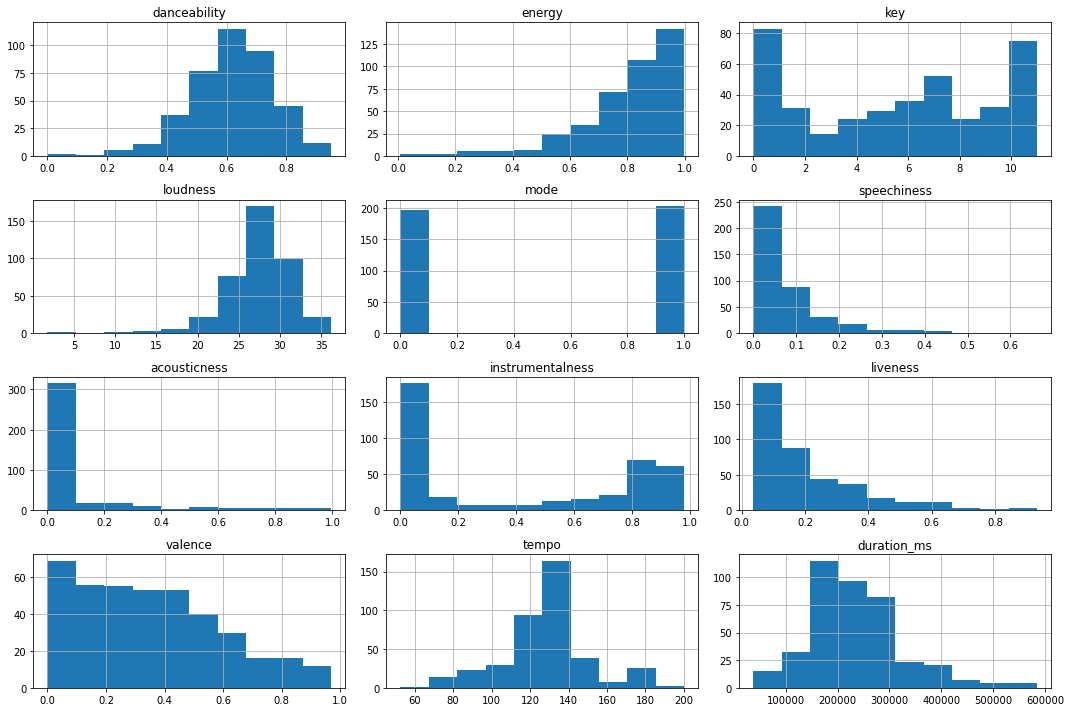

In [58]:
song_data.hist(figsize=(15,10));
plt.tight_layout()

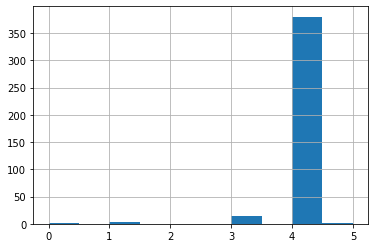

In [4]:
song_data_time = pd.read_csv('~\Documents\SpringboardNew\song_data.csv')
song_data_time.time_signature.hist()
plt.show()

All of these distributions seem to check out for the most part, but now I notice time_signature has some zero values, and almost every time signature is four. Also, we know that key, mode, and time signature are categorical, while the rest are continuous variables. <br><br>
I expect that we may not end up using the time signature column as it seems to have little value for our model due to its incredibly low variance in this data set. This makes sense for the genres included in this dataset, because they all use 4/4 time signature almost exclusively.

In [51]:
song_data = song_data.drop('time_signature', axis=1)

In [52]:
song_data

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,Genre
song_name,,,,,,,,,,,,,
Ferrari,0.844,0.688,1,26.121,0,0.0490,0.01290,0.000054,0.0492,0.695,124.992,185662,House
Baby Don't Hurt Me,0.602,0.910,7,30.596,1,0.0308,0.00126,0.000174,0.1200,0.228,127.944,140018,House
Miss You,0.587,0.742,6,27.360,0,0.0529,0.01280,0.001070,0.1460,0.199,145.007,206000,House
I'm Good (Blue),0.561,0.965,7,30.327,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,175238,House
The Motto,0.754,0.763,7,29.373,0,0.0435,0.03010,0.000022,0.0901,0.464,117.953,164819,House
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Better Time,0.793,0.440,7,28.365,1,0.0370,0.23400,0.000373,0.0875,0.187,120.023,196062,Electro
Take My Love,0.672,0.955,8,28.234,0,0.0434,0.00626,0.518000,0.2700,0.255,126.020,194286,Electro
Good Life - feat. mimiko,0.680,0.841,0,27.970,1,0.0395,0.00562,0.000081,0.1420,0.190,123.029,227562,Electro


In [53]:
song_data.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
Genre               0
dtype: int64

In [54]:
song_data.to_csv('~\Documents\SpringboardNew\song_data2.csv')